In [1]:
import numpy as np
import os
import urllib
import gzip
import struct
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
def download_data(url, force_download=True): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.urlretrieve(url, fname)
    return fname

def read_data(label_url, image_url):
    with gzip.open(label_url) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(image_url, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

path='handwritten-digits/'
(train_lbl, train_img) = read_data(
    path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data(
    path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

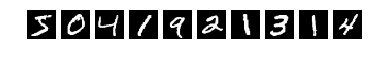

label: [5 0 4 1 9 2 1 3 1 4]


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % (train_lbl[0:10],))

In [3]:
train_lbl[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int8)

In [4]:
import mxnet as mx

def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

batch_size = 100
train_iter = mx.io.NDArrayIter(to4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(val_img), val_lbl, batch_size)

In [ ]:
data = mx.symbol.Variable('data')
# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# first fullc layer
flatten = mx.sym.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
# second fullc
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)
# softmax loss
lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

In [ ]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
model = mx.model.FeedForward(
    ctx = mx.gpu(0),     # use GPU 0 for training, others are same as before
    symbol = lenet,       
    num_epoch = 10,     
    learning_rate = 0.1)
model.fit(
    X=train_iter,  
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 200)
)

INFO:root:Start training with [gpu(0)]
INFO:root:Epoch[0] Batch [200]	Speed: 11436.71 samples/sec	Train-accuracy=0.098850
INFO:root:Epoch[0] Batch [400]	Speed: 11509.65 samples/sec	Train-accuracy=0.100000
INFO:root:Epoch[0] Batch [600]	Speed: 11435.95 samples/sec	Train-accuracy=0.097300
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=5.520
INFO:root:Epoch[0] Validation-accuracy=0.098000
INFO:root:Epoch[1] Batch [200]	Speed: 11618.76 samples/sec	Train-accuracy=0.098850
INFO:root:Epoch[1] Batch [400]	Speed: 11105.13 samples/sec	Train-accuracy=0.100000
INFO:root:Epoch[1] Batch [600]	Speed: 11445.94 samples/sec	Train-accuracy=0.097300
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=5.288
INFO:root:Epoch[1] Validation-accuracy=0.098000
INFO:root:Epoch[2] Batch [200]	Speed: 11546.46 samples/sec	Train-accuracy=0.098850
INFO:root:Epoch[2] Batch [400]	Speed: 11541.21 samples/sec	Train-accuracy=0.100000
INFO:root:Epoch[2] Batch [600]	Speed: 11510.4